In [1]:


import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:


# ------------------------------
# 1. Load Data and Prepare Features
# ------------------------------
file_path = 'datesBrokenUp_MovingAVG_FINAL_DATA_rcalix.csv'
df = pd.read_csv(file_path)


In [3]:

# Use all numeric columns except "Unnamed: 0" and "Date_Map" (which total 35 columns)
# (Assumption: this recovers the 35 features you mention.)
features = df.drop(columns=["Unnamed: 0", "Date_Map"]).reset_index(drop=True)

# Get target vector SI_f1 (we assume column name exactly "SI_f1")
target = features["SI_f1"].values
features = features.values  # now shape (1394, 35)

print( features.shape )


(1394, 35)


In [4]:

# ------------------------------
# 2. Utility functions: Data windowing
# ------------------------------
def create_sliding_windows(data, target, input_len=10, pred_len=9):
    """
    Create training samples from a continuous block of data.
    Each sample: input data of length input_len (all features) and target: next pred_len values of SI_f1.
    data: np.array of shape (T, num_features)
    target: np.array of shape (T,)
    Returns two arrays: inputs of shape (N, input_len, num_features) and targets (N, pred_len)
    """
    X, Y = [], []
    T = len(data)
    for i in range(T - input_len - pred_len + 1):
        X.append(data[i:i+input_len, :])
        Y.append(target[i+input_len:i+input_len+pred_len])
    return np.array(X), np.array(Y)


In [5]:



# ------------------------------
# 3. Define a simple Transformer-based model (GPT-like)
# ------------------------------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=35, d_model=64, nhead=8, num_layers=2, input_len=10, pred_len=9):
        super(TimeSeriesTransformer, self).__init__()
        self.input_len = input_len
        self.pred_len = pred_len
        self.d_model = d_model
        
        # Project the input features to d_model dimensions (like an embedding)
        self.input_proj = nn.Linear(feature_size, d_model)
        
        # Positional encoding (using a simple learnable embedding per position)
        self.pos_embedding = nn.Parameter(torch.randn(input_len, d_model))
        
        # Transformer encoder layers (a simplified “GPT-like” block but without autoregressive decoding)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # For forecasting, we map the aggregated output to pred_len predictions.
        # One approach is to simply average (or take the last token) and then map.
        self.head = nn.Linear(d_model, pred_len)
        
    def forward(self, x):
        # x: [batch, input_len, feature_size]
        batch_size = x.size(0)
        # Project to d_model
        x = self.input_proj(x)  # [batch, input_len, d_model]
        # Add positional encoding: broadcast pos_embedding to batch size
        x = x + self.pos_embedding.unsqueeze(0)  # [batch, input_len, d_model]
        # Transformer expects shape (input_len, batch, d_model)
        x = x.transpose(0, 1)
        encoded = self.transformer_encoder(x)  # [input_len, batch, d_model]
        # Take the final token representation (alternatively, one could pool over time)
        last_token = encoded[-1, :, :]  # [batch, d_model]
        out = self.head(last_token)  # [batch, pred_len]
        return out



In [6]:

# Replace the transformer model with a simple GRU model
class GRUForecast(nn.Module):
    def __init__(self, input_size=34, hidden_size=64, num_layers=1, pred_len=9):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.head = nn.Linear(hidden_size, pred_len)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # Take the last output
        return self.head(out)



In [7]:


# ------------------------------
# 4. Training and Evaluation per window size
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_evaluate(window_size, pivot=560, input_len=10, pred_len=9, epochs=50):
    """
    For a given window size, use the data preceding pivot (of length = window_size) to 
    create training samples (via sliding windows). Then, train a model and evaluate on the
    sample at the pivot index (using the 10 steps immediately preceding pivot).
    
    Returns: training loss, test MSE, test RMSE, predictions and ground truth.
    """
    # Determine training data: from pivot - window_size up to pivot.
    train_data = features[pivot - window_size : pivot, :]
    train_target = target[pivot - window_size : pivot]
    
    # Create sliding windows for training
    X_train, Y_train = create_sliding_windows(train_data, train_target, input_len, pred_len)
    print(f"Window size {window_size}: {len(X_train)} training samples.")
    
    # Convert to Torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
    
    # Create our model instance
    ## model = TimeSeriesTransformer(feature_size=35, d_model=64, nhead=8, num_layers=2,
    ##                               input_len=input_len, pred_len=pred_len).to(device)
    

    model = GRUForecast(input_size=35, hidden_size=64, num_layers=1, pred_len=9).to(device)

    # Also move your data to the same device
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)


    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Window {window_size} Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    # Evaluate on the test sample: the 10 steps immediately before the pivot.
    X_test = features[pivot - input_len:pivot, :][None, ...]  # shape (1, 10, 35)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        pred = model(X_test).cpu().numpy().flatten()
    # Ground truth: next pred_len points after pivot
    y_true = target[pivot:pivot+pred_len]
    
    # Metrics
    mse = np.mean((pred - y_true) ** 2)
    rmse = np.sqrt(mse)
    
    return model, loss.item(), mse, rmse, pred, y_true



In [8]:

# ------------------------------
# 5. Train four models on different window sizes and plot results
# ------------------------------
window_sizes = [100, 200, 300, 400]
results = {}



--- Training with window size: 100 ---
Window size 100: 82 training samples.
Window 100 Epoch [10/50], Loss: 0.5358
Window 100 Epoch [20/50], Loss: 0.2768
Window 100 Epoch [30/50], Loss: 0.1617
Window 100 Epoch [40/50], Loss: 0.0919
Window 100 Epoch [50/50], Loss: 0.0692
Window 100: Test MSE: 0.6317, RMSE: 0.7948


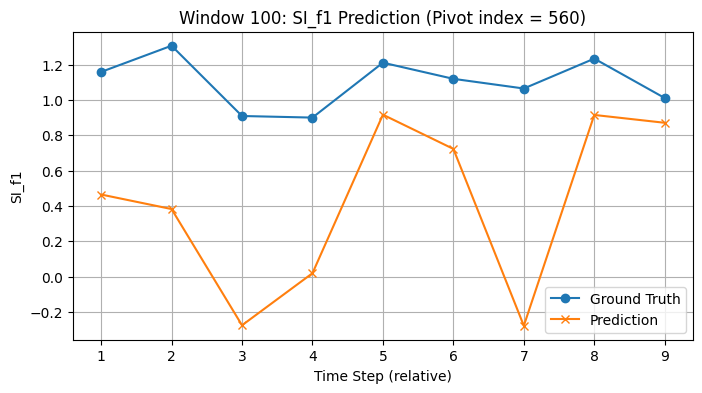


--- Training with window size: 200 ---
Window size 200: 182 training samples.
Window 200 Epoch [10/50], Loss: 0.4499
Window 200 Epoch [20/50], Loss: 0.1920
Window 200 Epoch [30/50], Loss: 0.0937
Window 200 Epoch [40/50], Loss: 0.0565
Window 200 Epoch [50/50], Loss: 0.0468
Window 200: Test MSE: 0.1012, RMSE: 0.3181


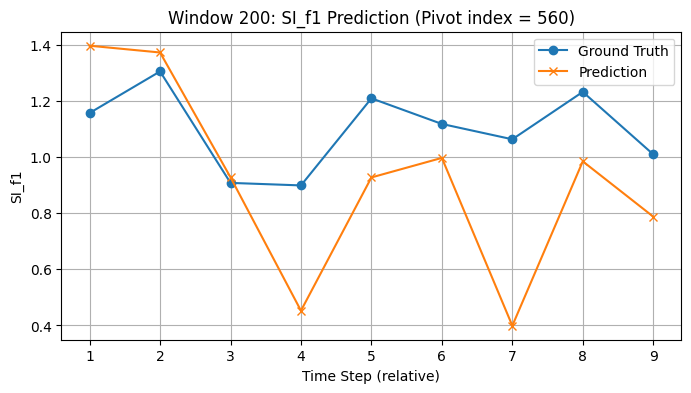


--- Training with window size: 300 ---
Window size 300: 282 training samples.
Window 300 Epoch [10/50], Loss: 0.4750
Window 300 Epoch [20/50], Loss: 0.2367
Window 300 Epoch [30/50], Loss: 0.1566
Window 300 Epoch [40/50], Loss: 0.1199
Window 300 Epoch [50/50], Loss: 0.1014
Window 300: Test MSE: 0.2618, RMSE: 0.5117


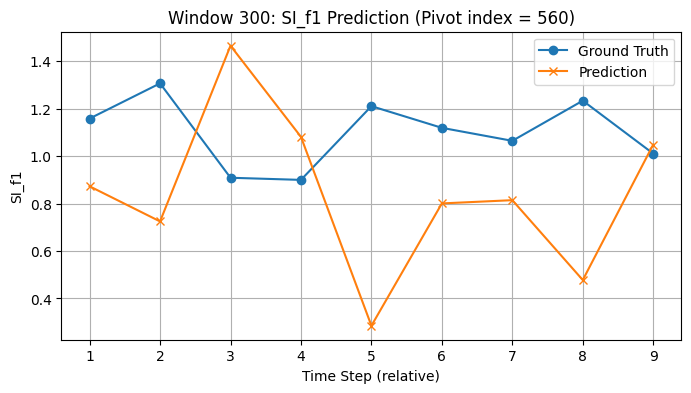


--- Training with window size: 400 ---
Window size 400: 382 training samples.
Window 400 Epoch [10/50], Loss: 0.5481
Window 400 Epoch [20/50], Loss: 0.2188
Window 400 Epoch [30/50], Loss: 0.1272
Window 400 Epoch [40/50], Loss: 0.1053
Window 400 Epoch [50/50], Loss: 0.0949
Window 400: Test MSE: 0.2363, RMSE: 0.4861


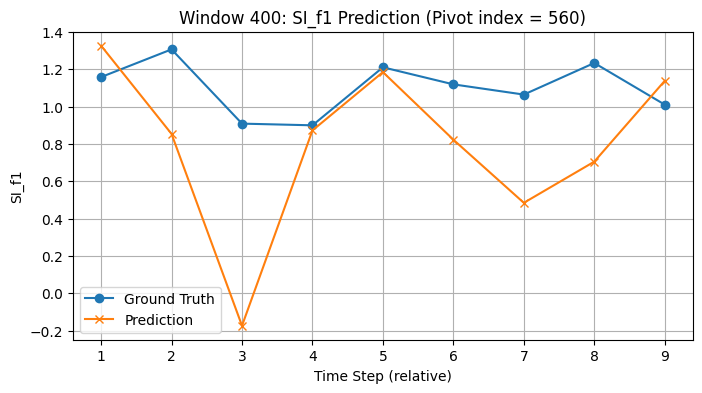

In [9]:


for ws in window_sizes:
    print(f"\n--- Training with window size: {ws} ---")
    model, final_loss, mse, rmse, pred, y_true = train_and_evaluate(ws, pivot=560, epochs=50)
    results[ws] = {
        "final_loss": final_loss,
        "mse": mse,
        "rmse": rmse,
        "pred": pred,
        "y_true": y_true
    }
    print(f"Window {ws}: Test MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    
    # Plot predictions vs. ground truth
    plt.figure(figsize=(8, 4))
    
    plt.plot(range(1, len(y_true) + 1), y_true, marker='o', label="Ground Truth")
    plt.plot(range(1, len(pred) + 1), pred, marker='x', label="Prediction")

    plt.title(f"Window {ws}: SI_f1 Prediction (Pivot index = 560)")
    plt.xlabel("Time Step (relative)")
    plt.ylabel("SI_f1")
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:

    
# Finally, you can compare performance across window sizes.
print("\nSummary Performance:")
for ws in window_sizes:
    res = results[ws]
    print(f"Window {ws}: Final Train Loss: {res['final_loss']:.4f}, Test MSE: {res['mse']:.4f}, RMSE: {res['rmse']:.4f}")




Summary Performance:
Window 100: Final Train Loss: 0.0692, Test MSE: 0.6317, RMSE: 0.7948
Window 200: Final Train Loss: 0.0468, Test MSE: 0.1012, RMSE: 0.3181
Window 300: Final Train Loss: 0.1014, Test MSE: 0.2618, RMSE: 0.5117
Window 400: Final Train Loss: 0.0949, Test MSE: 0.2363, RMSE: 0.4861
